# 0. Import Dependencies

In [2]:
import os
import cv2
import easyocr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

# 1. Setup Paths

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [4]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [5]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [6]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 2. Load Image

In [7]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'cir_1.jpg')

In [9]:
reader = easyocr.Reader(['en'], gpu=True)
result = reader.readtext(IMAGE_PATH)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[276, 134], [338, 134], [338, 166], [276, 166]], '10', 0.9991350876748208),
 ([[462, 126], [526, 126], [526, 158], [462, 158]],
  '20n',
  0.29747108247814286),
 ([[362, 200], [434, 200], [434, 232], [362, 232]],
  '7.50',
  0.4368730050291126),
 ([[30, 236], [90, 236], [90, 268], [30, 268]], '12v', 0.5892688028398779),
 ([[276, 314], [338, 314], [338, 346], [276, 346]], '30n', 0.7989892689676568),
 ([[558, 320], [604, 320], [604, 352], [558, 352]], '52', 0.5999067972034773)]

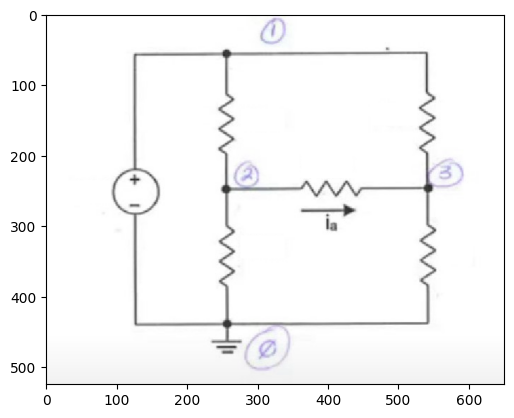

In [10]:
img = cv2.imread(IMAGE_PATH)
font = cv2.FONT_HERSHEY_DUPLEX
for i in range(len(result)):
    top_left = (result[i][0][0])
    bottom_right = (result[i][0][2])
    text = result[i][1]
    img = cv2.rectangle(img, top_left, bottom_right, (255, 255, 255), -1)
#     img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 5)
#     img = cv2.putText(img, text, top_left, font, .5, (0, 0, 0), 2, cv2.LINE_AA)
    
plt.imshow(img)
plt.show()

In [12]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-21')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [14]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

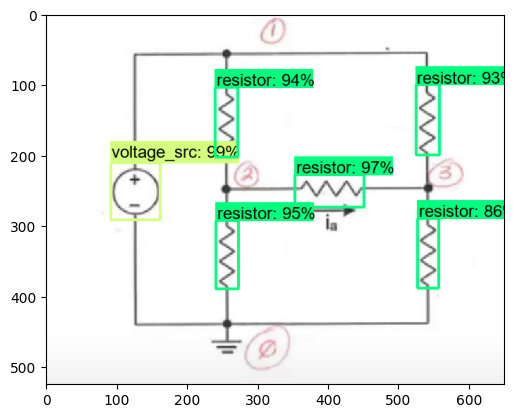

In [15]:
# img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=10,
            min_score_thresh=.80,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

[['voltage_src', [211, 91, 291, 162]], ['resistor', [228, 352, 273, 451]], ['resistor', [293, 240, 389, 273]], ['resistor', [104, 239, 202, 272]], ['resistor', [100, 524, 199, 558]], ['resistor', [290, 526, 388, 557]]]


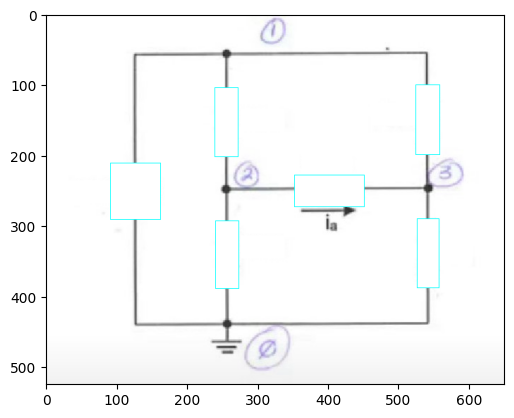

In [16]:
threshold = 0.80
device_bounding_boxes = []

img_height, img_width, _ = img.shape
for index, content in enumerate(detections['detection_boxes']):
    if detections['detection_scores'][index] > threshold:
        y_min, x_min, y_max, x_max = content
        y_min, x_min, y_max, x_max = np.float32(y_min), np.float32(x_min), np.float32(y_max), np.float32(x_max)
        y_min, x_min, y_max, x_max = y_min.item(), x_min.item(), y_max.item(), x_max.item()
        top_left = (int(x_min * img_width), int(y_min * img_height))
        bottom_right = (int(x_max * img_width), int(y_max * img_height))
        
        # Search points
        bounding_boxes_limits = ([int(y_min * img_height), int(x_min * img_width), int(y_max * img_height), int(x_max * img_width)])
        class_index = detections['detection_classes'][index]+label_id_offset
        device_bounding_boxes.append([category_index.get(class_index)['name'], bounding_boxes_limits])
        
        # Drawing rectangles
        img = cv2.rectangle(img, top_left, bottom_right, (255, 255, 255), -1)
        img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 255), 1)
print(device_bounding_boxes)
plt.imshow(img)
plt.show()

In [17]:
if device_bounding_boxes[0][0] != 'current_src' or device_bounding_boxes[0][0] != 'voltage_src':
    for index, element in enumerate(device_bounding_boxes):
        if element[0] == 'current_src' or element[0] == 'voltage_src':
            device_bounding_boxes[0], device_bounding_boxes[index] = device_bounding_boxes[index], device_bounding_boxes[0]
            break

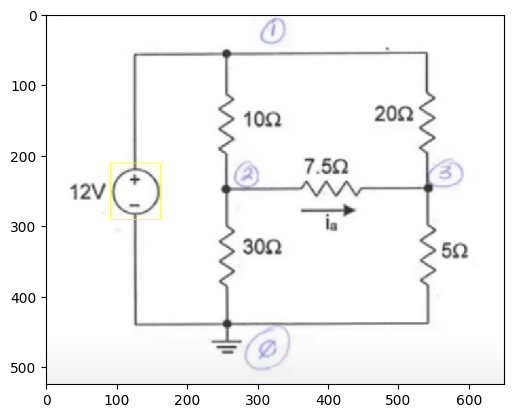

Enter the device value only: 12


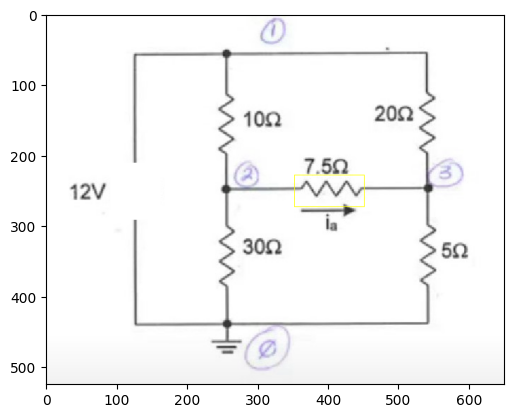

Enter the device value only: 7.5


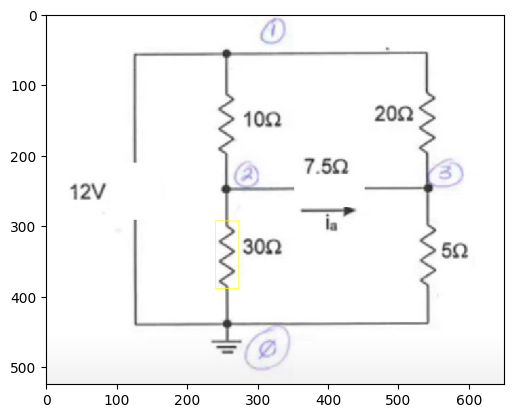

Enter the device value only: 30


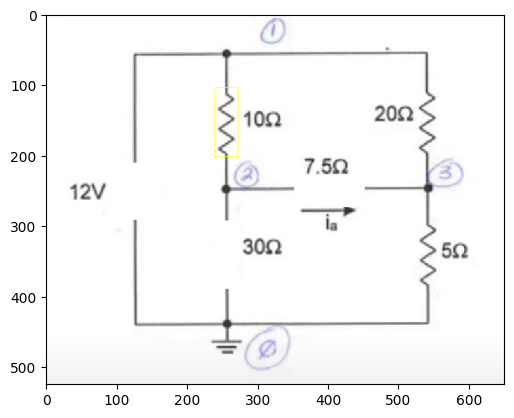

Enter the device value only: 10


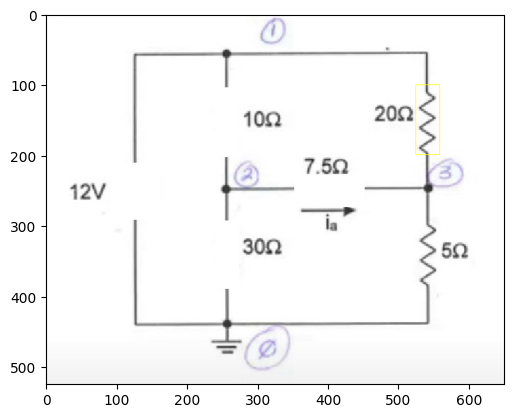

Enter the device value only: 20


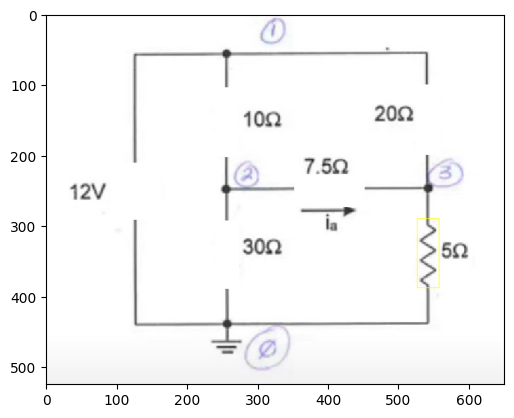

Enter the device value only: 5


In [18]:
image = cv2.imread(IMAGE_PATH)
for index, elements in enumerate(device_bounding_boxes):
    
    y_min, x_min, y_max, x_max = device_bounding_boxes[index][1]
    top_left = (x_min, y_min)
    bottom_right = (x_max, y_max)

    image = cv2.rectangle(image, top_left, bottom_right, (255, 255, 0), 1)
    plt.imshow(image)
    plt.show()
    
    value = input("Enter the device value only: ")
    device_bounding_boxes[index].append(value)
    image = cv2.rectangle(image, top_left, bottom_right, (255, 255, 255), -1)

In [19]:
def x_correct_path(y_check_pt, x_check_pt):
    
    """
    x_check_pt += 5 or x_check_pt -= 5
    """
    y_min_check_pt = y_check_pt - 8 
    y_max_check_pt = y_check_pt + 8
    
    array = np.array(img[y_min_check_pt:y_max_check_pt, x_check_pt])
    path_exists = np.any(np.all(array == [255, 0, 0], axis=1))
    
    if path_exists:
        wire_color = [255, 0, 0]
        indices = np.where(np.all(array == wire_color, axis=1))[0]
        index = indices[0] if indices.size > 0 else None
        y_check_pt = y_min_check_pt + index
        
    else:
        min_values = array.min(axis=0)
        min_indices = array.argmin(axis=0)
        
        if np.all(min_indices == min_indices[0]):
            min_index = min_indices[0]
            y_check_pt = y_min_check_pt + min_index
            
        else:
            min_index = np.bincount(min_indices).argmax()
            y_check_pt = y_min_check_pt + min_index
    
    return y_check_pt 

In [20]:
def y_correct_path(y_check_pt, x_check_pt):
    """
    y_check_pt += 5 or y_check_pt -= 5
    
    """
    
    x_min_check_pt = x_check_pt - 8 
    x_max_check_pt = x_check_pt + 8
    
    array = np.array(img[y_check_pt, x_min_check_pt:x_max_check_pt])
    path_exists = np.any(np.all(array == [255, 0, 0], axis=1))
    
    if path_exists:
        wire_color = [255, 0, 0]
        indices = np.where(np.all(array == wire_color, axis=1))[0]
        index = indices[0] if indices.size > 0 else None
        x_check_pt = x_min_check_pt + index
        
    else:
        min_values = array.min(axis=0)
        min_indices = array.argmin(axis=0)
        
        if np.all(min_indices == min_indices[0]):
            min_index = min_indices[0]
            x_check_pt = x_min_check_pt + min_index

        else:
            min_index = np.bincount(min_indices).argmax()
            x_check_pt = x_min_check_pt + min_index
            
    return x_check_pt 

In [21]:
def x_moving_direction(y_check_pt, x_check_pt, red_overlap, pos_direction = True):
    
    if pos_direction ==  True:
        index = 0
        while index < img.shape[1] - x_check_pt:
            red = img[y_check_pt, x_check_pt + index][0]
            green = img[y_check_pt, x_check_pt + index][1]
            blue = img[y_check_pt, x_check_pt + index][2]
            
            if len(node_list) > 1:
                if node_list[-1][0] == y_check_pt and node_list[-2][0] == y_check_pt and node_list[-1][1] == x_check_pt + index - 1 and node_list[-2][1] == x_check_pt + index - 2:
                    node_list.pop()
                    red_overlap = True
                    break
            
            if red == 255 and green == 0 and blue == 0 and [y_check_pt, x_check_pt + index] not in node_list:
                node_list.append([y_check_pt, x_check_pt + index])
            
            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                img[y_check_pt, x_check_pt + index] = [255, 0, 0]
                index += 1
                
            else:
                x_check_pt = x_check_pt + index
                break
    else:
        index = x_check_pt
        while index > 0 or index < img.shape[1] - 1:
            red = img[y_check_pt, index][0]
            green = img[y_check_pt, index][1]
            blue = img[y_check_pt, index][2]
            
            if len(node_list) > 1:
                if node_list[-1][0] == y_check_pt and node_list[-2][0] == y_check_pt and node_list[-1][1] == index + 1 and node_list[-2][1] == index + 2:
                    node_list.pop()
                    red_overlap = True
                    break
                
            if red == 255 and green == 0 and blue == 0 and [y_check_pt, index] not in node_list:
                node_list.append([y_check_pt, index])
            
            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                x_check_pt = index
                img[y_check_pt, x_check_pt] = [255, 0, 0]
                index -= 1
                
            else:
                break
                
    plt.imshow(img)
    plt.show()           
    return x_check_pt, y_check_pt, red_overlap

In [22]:
def y_moving_direction(y_check_pt, x_check_pt, red_overlap, pos_direction = False):
    
    if pos_direction ==  True:
        index = 0
        while index < img.shape[0] - y_check_pt:
            red = img[y_check_pt + index, x_check_pt][0]
            green = img[y_check_pt + index, x_check_pt][1]
            blue = img[y_check_pt + index, x_check_pt][2]
            
            if len(node_list) > 1:
                if node_list[-1][0] == y_check_pt + index - 1 and node_list[-2][0] == y_check_pt + index - 2 and node_list[-2][1] == x_check_pt and node_list[-1][1] == x_check_pt:
                    node_list.pop()
                    red_overlap = True
                    break
                    
            if red == 255 and green == 0 and blue == 0 and [y_check_pt + index, x_check_pt] not in node_list:
                node_list.append([y_check_pt + index, x_check_pt])

            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                img[y_check_pt + index, x_check_pt] = [255, 0, 0]
                index += 1
                
            else:
                y_check_pt = y_check_pt + index
                break
    else:
        index = y_check_pt
        while index > 0 or index < img.shape[0] - 1:
            red = img[index, x_check_pt][0]
            green = img[index, x_check_pt][1]
            blue = img[index, x_check_pt][2]
            
            if len(node_list) > 1:
                if node_list[-1][0] == index + 1 and node_list[-2][0] == index + 2 and node_list[-2][1] == x_check_pt and node_list[-1][1] == x_check_pt:
                    node_list.pop()
                    red_overlap = True
                    break
                    
            if red == 255 and green == 0 and blue == 0 and [index, x_check_pt] not in node_list:
                node_list.append([index, x_check_pt])
            
            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                y_check_pt = index
                img[y_check_pt, x_check_pt] = [255, 0, 0]
                index -= 1
                
            else:
                break
                
    plt.imshow(img)
    plt.show()           
    return x_check_pt, y_check_pt, red_overlap

In [23]:
def check_path(img, x_check_pt, y_check_pt, testing = False):
    # Define the size of the region and offset
    region_size = 8
    offset = 10
    
    # Function to get the average RGB values for a region
    def get_avg_rgb(region):
        avg_color = np.mean(region, axis=(0,1))
        return avg_color

    # Extract regions further away and compute average RGB values for each direction
    left_region = img[y_check_pt - region_size//2:y_check_pt + region_size//2, x_check_pt - offset - region_size:x_check_pt - offset]
    avg_red_left, avg_green_left, avg_blue_left = get_avg_rgb(left_region)

    right_region = img[y_check_pt - region_size//2:y_check_pt + region_size//2, x_check_pt + offset:x_check_pt + offset + region_size]
    avg_red_right, avg_green_right, avg_blue_right = get_avg_rgb(right_region)

    up_region = img[y_check_pt - offset - region_size:y_check_pt - offset, x_check_pt - region_size//2:x_check_pt + region_size//2]
    avg_red_up, avg_green_up, avg_blue_up = get_avg_rgb(up_region)

    down_region = img[y_check_pt + offset:y_check_pt + offset + region_size, x_check_pt - region_size//2:x_check_pt + region_size//2]
    avg_red_down, avg_green_down, avg_blue_down = get_avg_rgb(down_region)

    # Check if the average color values exceed 200 for each channel
    left_blocked = avg_red_left > 200 and avg_green_left > 200 and avg_blue_left > 200
    right_blocked = avg_red_right > 200 and avg_green_right > 200 and avg_blue_right > 200
    up_blocked = avg_red_up > 200 and avg_green_up > 200 and avg_blue_up > 200
    down_blocked = avg_red_down > 200 and avg_green_down > 200 and avg_blue_down > 200

    if testing:
        
        # Color the regions in the image
        red_color = [0, 0, 255] # changed to blue 
        green_color = [255, 0, 0] # changed to red 

        if left_blocked:
            left_region[:,:] = red_color
        else:
            left_region[:,:] = green_color

        if right_blocked:
            right_region[:,:] = red_color
        else:
            right_region[:,:] = green_color

        if up_blocked:
            up_region[:,:] = red_color
        else:
            up_region[:,:] = green_color

        if down_blocked:
            down_region[:,:] = red_color
        else:
            down_region[:,:] = green_color

        plt.imshow(img)
        plt.show()

    # Combine the blocked directions to provide a comprehensive response
    blocked_directions = []

    if left_blocked:
        blocked_directions.append("left")
    if right_blocked:
        blocked_directions.append("right")
    if up_blocked:
        blocked_directions.append("up")
    if down_blocked:
        blocked_directions.append("down")

    if not blocked_directions:
        return None  # No direction is blocked
    
    return blocked_directions


In [24]:
# Recursive function to navigate through the grid.
def navigate(img, x_check_pt, y_check_pt, visited, node_list, prev_direction=None, testing = False):
    
    red_overlap = False
    # Check if current position is out of bounds or in an invalid position.
    if x_check_pt < 0 or x_check_pt > img.shape[1] - 1 or y_check_pt < 0 or y_check_pt > img.shape[0] - 1:
        raise Exception("Exceed the image boundaries")
    
    # If we've been here before, don't revisit.
    if (x_check_pt, y_check_pt) in visited:
        return ("its existed")
    
    visited.add((x_check_pt, y_check_pt))

    # Check for blocked directions.
    blocked_directions = set()
    if prev_direction == 'down':  # If we came from below, we don't want to go back.
        blocked_directions.add('up')
    elif prev_direction == 'up':
        blocked_directions.add('down')
    elif prev_direction == 'left':
        blocked_directions.add('right')
    elif prev_direction == 'right':
        blocked_directions.add('left')

    # check for blocked directions
    checked_direction = check_path(img, x_check_pt, y_check_pt, testing)
    print("checked_direction", checked_direction)
    
    if checked_direction == None:
        return node_list
    
    blocked_directions.update(checked_direction)
    print("prev_direction", prev_direction)
    print("blocked_directions", blocked_directions)

    path = [(x_check_pt, y_check_pt)]
    directions = ['up', 'right', 'down', 'left']
    for direction in directions:
        if direction not in blocked_directions:
            
            print("direction", direction)
            if direction == 'up':
                x_check_pt = y_correct_path(y_check_pt - 5, x_check_pt)
                x_check_pt, y_check_pt, red_overlap = y_moving_direction(y_check_pt, x_check_pt, red_overlap, pos_direction = False)
            
            elif direction == 'left':
                y_check_pt = x_correct_path(y_check_pt, x_check_pt - 5)
                x_check_pt, y_check_pt, red_overlap = x_moving_direction(y_check_pt, x_check_pt, red_overlap, pos_direction = False)
                
            elif direction == 'right':
                y_check_pt = x_correct_path(y_check_pt, x_check_pt + 5)
                x_check_pt, y_check_pt, red_overlap = x_moving_direction(y_check_pt, x_check_pt, red_overlap, pos_direction = True)
                
            elif direction == 'down':
                x_check_pt = y_correct_path(y_check_pt + 5, x_check_pt)
                x_check_pt, y_check_pt, red_overlap = y_moving_direction(y_check_pt, x_check_pt, red_overlap, pos_direction = True)
                
                
            # Recursively navigate from the new position.
            if red_overlap:
                pass
    
            else:
                navigate(img, x_check_pt, y_check_pt, visited, node_list, direction)

    return node_list

In [25]:
print(device_bounding_boxes)

[['voltage_src', [211, 91, 291, 162], '12'], ['resistor', [228, 352, 273, 451], '7.5'], ['resistor', [293, 240, 389, 273], '30'], ['resistor', [104, 239, 202, 272], '10'], ['resistor', [100, 524, 199, 558], '20'], ['resistor', [290, 526, 388, 557], '5']]


In [26]:
def component_orientation(comp_orientation):
    """
    orientation of the device is verticle or horizontal
    if its verticle assume that ymin is the anode 
    if its horizontal assume that xmin is the anode
    """
    
    ymin, xmin, ymax, xmax = comp_orientation
    vertically_connected = check_path(img, int((xmax + xmin)/2),  ymin)
    horizontally_connected = check_path(img, xmin, int((ymax + ymin)/2))
    
    directions = ['up', 'right', 'down', 'left']
    for direction in directions:
        if direction not in vertically_connected:
            anode_starting_pts = ymin - 1, int((xmax + xmin)/2)
            cathode_starting_pts = ymax + 1, int((xmax + xmin)/2)
            orientation = 'V'
            
        elif direction not in horizontally_connected: 
            anode_starting_pts = int((ymax + ymin)/2), xmin - 1
            cathode_starting_pts = int((ymax + ymin)/2), xmax + 1
            orientation = 'H'
            
    return anode_starting_pts, cathode_starting_pts, orientation

210 126
292 126
checked_direction ['left', 'right', 'down']
prev_direction None
blocked_directions {'left', 'down', 'right'}
direction up


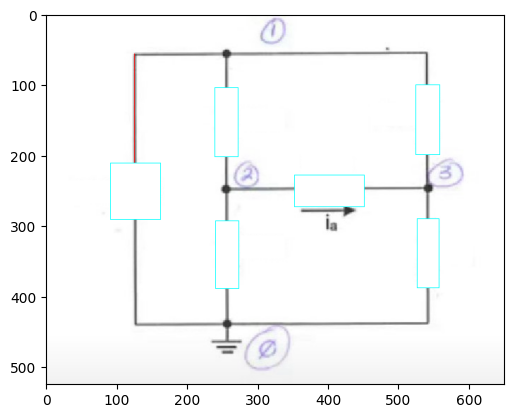

checked_direction ['left', 'up']
prev_direction up
blocked_directions {'left', 'down', 'up'}
direction right


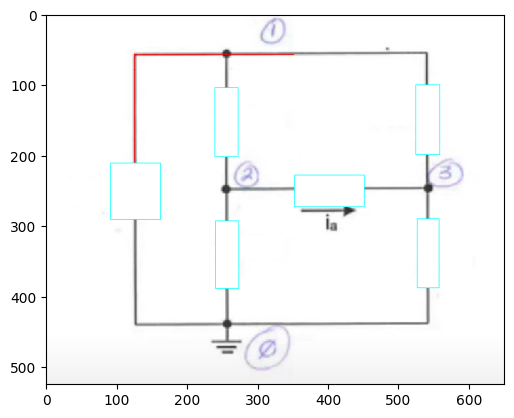

checked_direction ['up', 'down']
prev_direction right
blocked_directions {'left', 'down', 'up'}
direction right


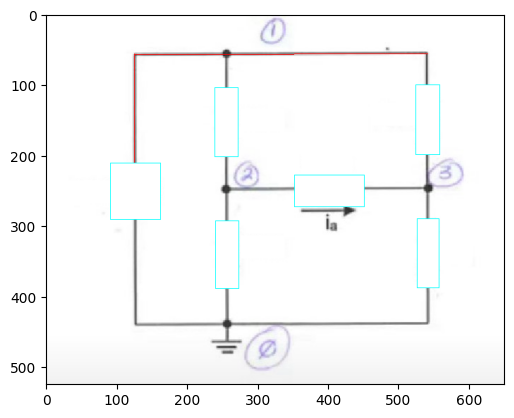

checked_direction ['right', 'up']
prev_direction right
blocked_directions {'left', 'right', 'up'}
direction down


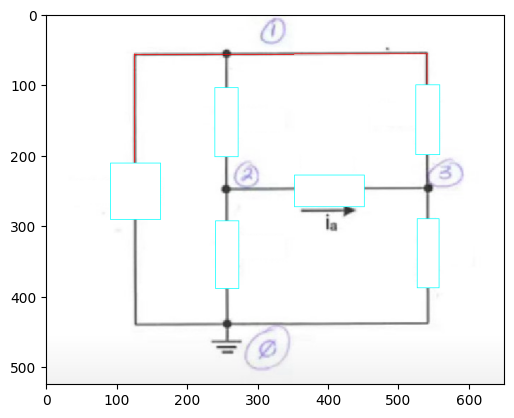

checked_direction ['left', 'right', 'down']
prev_direction down
blocked_directions {'left', 'down', 'right', 'up'}
checked_direction ['left', 'right', 'up']
prev_direction None
blocked_directions {'left', 'right', 'up'}
direction down


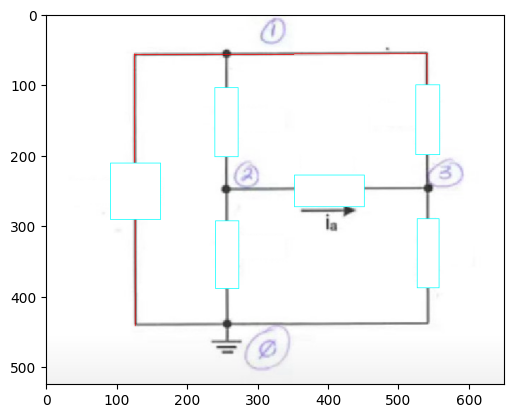

checked_direction ['left', 'right', 'down']
prev_direction down
blocked_directions {'left', 'down', 'right', 'up'}
250 351
250 452
checked_direction ['right', 'up', 'down']
prev_direction None
blocked_directions {'down', 'right', 'up'}
direction left


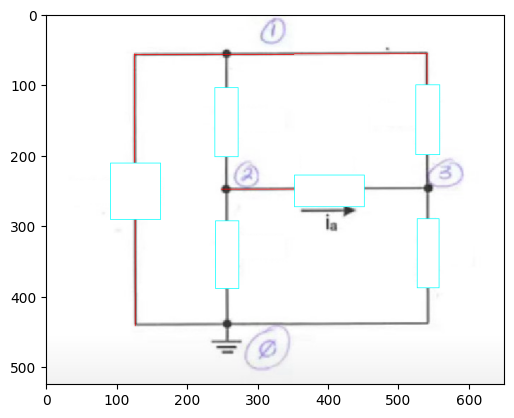

checked_direction ['left', 'up', 'down']
prev_direction left
blocked_directions {'left', 'down', 'right', 'up'}
checked_direction ['left', 'up', 'down']
prev_direction None
blocked_directions {'left', 'down', 'up'}
direction right


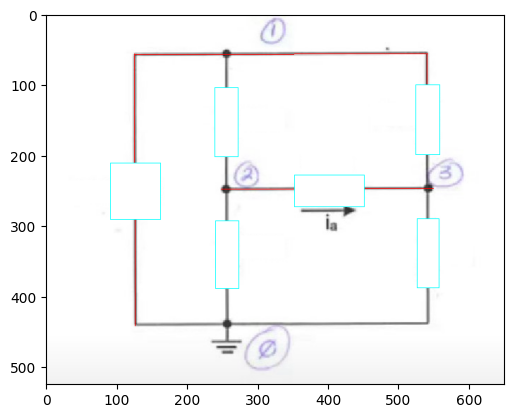

checked_direction ['right', 'up', 'down']
prev_direction right
blocked_directions {'left', 'down', 'right', 'up'}
292 256
390 256
checked_direction ['left', 'right', 'down']
prev_direction None
blocked_directions {'left', 'down', 'right'}
direction up


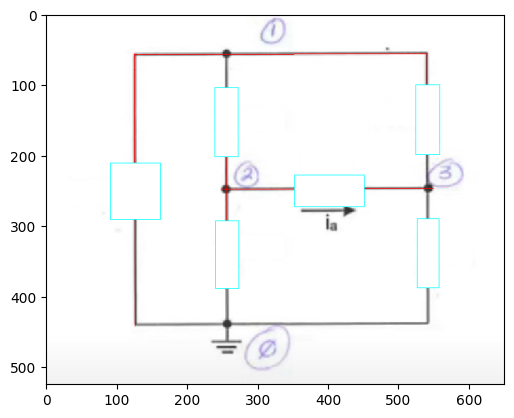

checked_direction ['left', 'right', 'up']
prev_direction up
blocked_directions {'left', 'down', 'right', 'up'}
checked_direction ['left', 'right', 'up']
prev_direction None
blocked_directions {'left', 'right', 'up'}
direction down


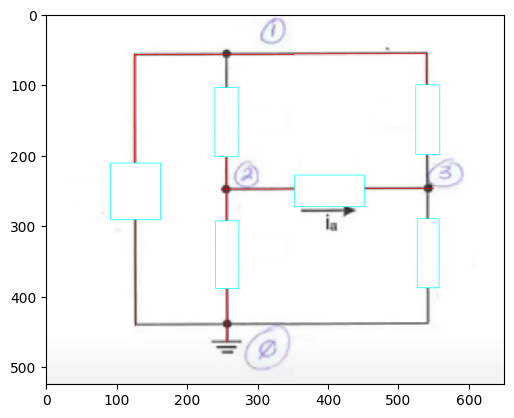

checked_direction None
103 255
203 255
checked_direction ['left', 'right', 'down']
prev_direction None
blocked_directions {'left', 'down', 'right'}
direction up


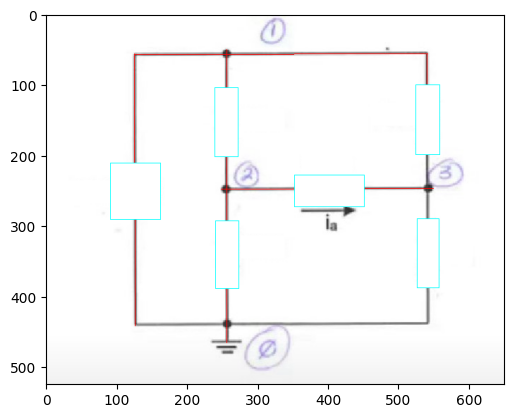

checked_direction ['left', 'right', 'up']
prev_direction up
blocked_directions {'left', 'down', 'right', 'up'}
99 541
200 541
checked_direction ['left', 'right', 'up']
prev_direction None
blocked_directions {'left', 'right', 'up'}
direction down


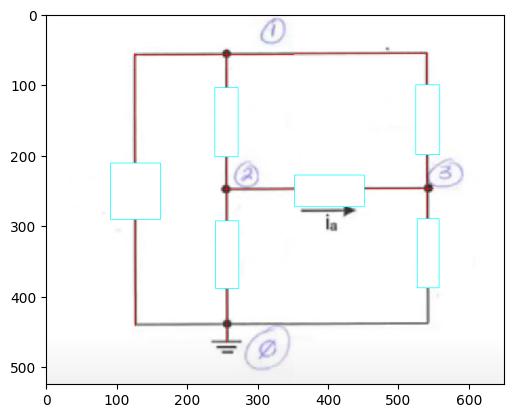

checked_direction ['left', 'right', 'down']
prev_direction down
blocked_directions {'left', 'down', 'right', 'up'}
289 541
389 541
checked_direction ['left', 'right', 'up']
prev_direction None
blocked_directions {'left', 'right', 'up'}
direction down


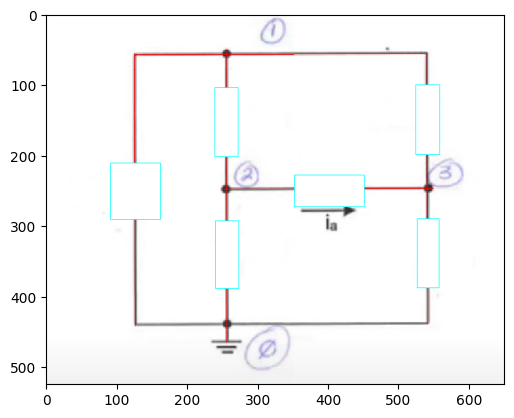

checked_direction ['right', 'down']
prev_direction down
blocked_directions {'down', 'right', 'up'}
direction left


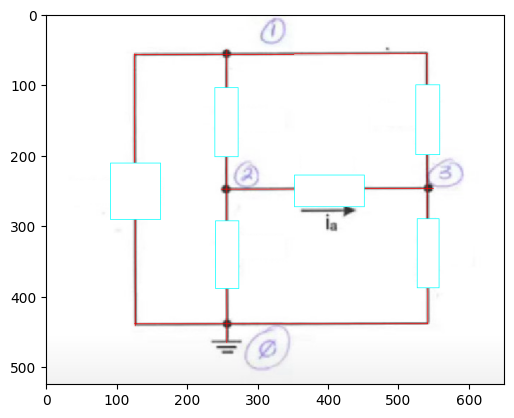

checked_direction ['left', 'down']
prev_direction left
blocked_directions {'left', 'down', 'right'}
direction up


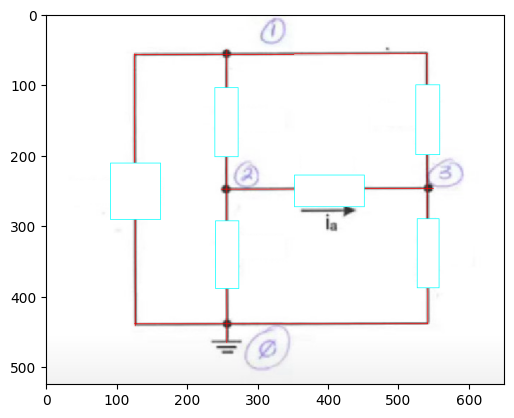

In [27]:
node_list = []
for index, elements in enumerate(device_bounding_boxes):
    anode_starting_pts, cathode_starting_pts, orientation = component_orientation(device_bounding_boxes[index][1])
    y_check_pt_anode, x_check_pt_anode = anode_starting_pts
    y_check_pt_cathode, x_check_pt_cathode = cathode_starting_pts
    print(y_check_pt_anode, x_check_pt_anode)
    print(y_check_pt_cathode, x_check_pt_cathode)
    
    #check if the starting pts is red
    if orientation == "V":
        x_check_pt_anode = y_correct_path(y_check_pt_anode, x_check_pt_anode)
        x_check_pt_cathode = y_correct_path(y_check_pt_cathode, x_check_pt_cathode)
        
        if np.array_equal(img[y_check_pt_anode, x_check_pt_anode], [255, 0, 0]):
            pass
        
        else:
            start_x, start_y = x_check_pt_anode, y_check_pt_anode
            visited = set()
            sub_lists = navigate(img, start_x, start_y, visited, node_list, prev_direction=None)
            for sub_list in sub_lists:
                if sub_list not in node_list:
                    node_list.append(sub_list)
            
        
        if np.array_equal(img[y_check_pt_cathode, x_check_pt_cathode], [255, 0, 0]):
            pass
        
        else:
            start_x, start_y = x_check_pt_cathode, y_check_pt_cathode
            visited = set()
            sub_lists = navigate(img, start_x, start_y, visited, node_list, prev_direction=None)
            for sub_list in sub_lists:
                if sub_list not in node_list:
                    node_list.append(sub_list)      
    
    elif orientation == "H":
        y_check_pt_anode = x_correct_path(y_check_pt_anode, x_check_pt_anode)
        y_check_pt_cathode = x_correct_path(y_check_pt_cathode, x_check_pt_cathode)
        
        if np.array_equal(img[y_check_pt_anode, x_check_pt_anode], [255, 0, 0]):
            pass
        
        else:
            start_x, start_y = x_check_pt_anode, y_check_pt_anode
            visited = set()
            sub_lists = navigate(img, start_x, start_y, visited, node_list, prev_direction=None)
            for sub_list in sub_lists:
                if sub_list not in node_list:
                    node_list.append(sub_list)
                
        if np.array_equal(img[y_check_pt_cathode, x_check_pt_cathode], [255, 0, 0]):
            pass
        
        else:
            start_x, start_y = x_check_pt_cathode, y_check_pt_cathode
            visited = set()
            sub_lists = navigate(img, start_x, start_y, visited, node_list, prev_direction=None)
            for sub_list in sub_lists:
                if sub_list not in node_list:
                    node_list.append(sub_list)

In [28]:
print(node_list)

[[57, 125], [56, 540], [248, 256], [57, 256], [247, 540], [439, 541], [439, 256], [439, 126]]


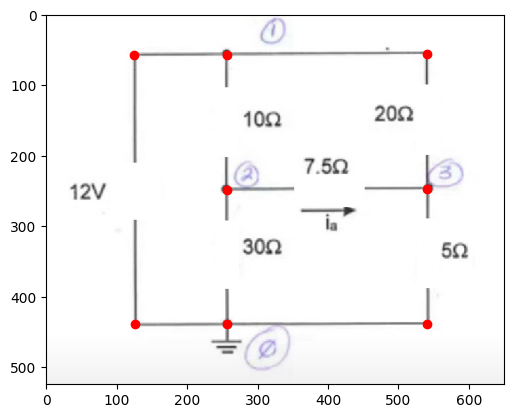

In [29]:
# Unpack nodes for plotting
y_vals, x_vals = zip(*node_list)

# Plot the image
plt.imshow(image.astype(np.uint8))

# Plot the nodes (in red color with 'o' marker)
plt.scatter(x_vals, y_vals, c='red', marker='o')

plt.show()

In [43]:
def x_moving_direction_node_checking(y_check_pt, x_check_pt, node_device, pos_direction = True):
    
    if pos_direction ==  True:
        index = 0
        while index < img.shape[1] - x_check_pt:
            red = img[y_check_pt, x_check_pt + index][0]
            green = img[y_check_pt, x_check_pt + index][1]
            blue = img[y_check_pt, x_check_pt + index][2]
            
            if [y_check_pt, x_check_pt + index] in node_list and [y_check_pt, x_check_pt + index] not in node_device:
                node_device.append([y_check_pt, x_check_pt + index])
                
            if red == 255 and green == 0 and blue == 0:
                index += 1
            else:
                x_check_pt = x_check_pt + index
                break
    else:
        index = x_check_pt
        while index > 0 or index < img.shape[1] - 1:
            red = img[y_check_pt, index][0]
            green = img[y_check_pt, index][1]
            blue = img[y_check_pt, index][2]
            
            if [y_check_pt, index] in node_list and [y_check_pt, index] not in node_device:
                node_device.append([y_check_pt, index])
            
            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                x_check_pt = index
                index -= 1
                
            else:
                break
    
#     plt.imshow(img)
#     plt.show()           
    return x_check_pt, y_check_pt, node_device

In [44]:
def y_moving_direction_node_checking(y_check_pt, x_check_pt, node_device, pos_direction = False):
    
    if pos_direction ==  True:
        index = 0
        while index < img.shape[0] - y_check_pt:
            red = img[y_check_pt + index, x_check_pt][0]
            green = img[y_check_pt + index, x_check_pt][1]
            blue = img[y_check_pt + index, x_check_pt][2]
            
            if [y_check_pt + index, x_check_pt] in node_list and [y_check_pt + index, x_check_pt] not in node_device:
                node_device.append([y_check_pt + index, x_check_pt])

            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                index += 1
                
            else:
                y_check_pt = y_check_pt + index
                break
    else:
        index = y_check_pt
        while index > 0 or index < img.shape[0] - 1:
            red = img[index, x_check_pt][0]
            green = img[index, x_check_pt][1]
            blue = img[index, x_check_pt][2]
            
            if [index, x_check_pt] in node_list and  [index, x_check_pt] not in node_device:
                node_device.append([index, x_check_pt])
            
            if (red < 200 and green < 200 and blue < 200) or (red == 255 and green == 0 and blue == 0):
                y_check_pt = index
                index -= 1
                
            else:
                break
    
#     plt.imshow(img)
#     plt.show()           
    return x_check_pt, y_check_pt, node_device

In [45]:
# Recursive function to navigate through the grid.
def navigate_nodes(img, x_check_pt, y_check_pt, visited, node_device, prev_direction=None, testing = False):
    
    # Check if current position is out of bounds or in an invalid position.
    if x_check_pt < 0 or x_check_pt > img.shape[1] - 1 or y_check_pt < 0 or y_check_pt > img.shape[0] - 1:
        raise Exception("Exceed the image boundaries")
    
    # If we've been here before, don't revisit.
    if (x_check_pt, y_check_pt) in visited:
        return ("its existed")
    
    visited.add((x_check_pt, y_check_pt))

    # Check for blocked directions.
    blocked_directions = set()
    if prev_direction == 'down':  # If we came from below, we don't want to go back.
        blocked_directions.add('up')
    elif prev_direction == 'up':
        blocked_directions.add('down')
    elif prev_direction == 'left':
        blocked_directions.add('right')
    elif prev_direction == 'right':
        blocked_directions.add('left')

    # check for blocked directions
    checked_direction = check_path(img, x_check_pt, y_check_pt, testing)
    # print("checked_direction", checked_direction)
    
    if checked_direction == None:
        return node_device
    
    blocked_directions.update(checked_direction)
    # print("prev_direction", prev_direction)
    # print("blocked_directions", blocked_directions)

    path = [(x_check_pt, y_check_pt)]
    directions = ['up', 'right', 'down', 'left']
    for direction in directions:
        if direction not in blocked_directions:
            
            # print("direction", direction)
            if direction == 'up':
                x_check_pt = y_correct_path(y_check_pt - 5, x_check_pt)
                x_check_pt, y_check_pt, node_device = y_moving_direction_node_checking(y_check_pt, x_check_pt, node_device, pos_direction = False)
            
            elif direction == 'left':
                y_check_pt = x_correct_path(y_check_pt, x_check_pt - 5)
                x_check_pt, y_check_pt, node_device = x_moving_direction_node_checking(y_check_pt, x_check_pt, node_device, pos_direction = False)
                
            elif direction == 'right':
                y_check_pt = x_correct_path(y_check_pt, x_check_pt + 5)
                x_check_pt, y_check_pt, node_device = x_moving_direction_node_checking(y_check_pt, x_check_pt, node_device, pos_direction = True)
                
            elif direction == 'down':
                x_check_pt = y_correct_path(y_check_pt + 5, x_check_pt)
                x_check_pt, y_check_pt, node_device = y_moving_direction_node_checking(y_check_pt, x_check_pt, node_device, pos_direction = True)
                
                
            # Recursively navigate from the new position.
            navigate_nodes(img, x_check_pt, y_check_pt, visited, node_device, direction)

    return node_device

In [46]:
anode_same_device_counter = 1
cathode_same_device_counter = 1
node_devices = []
for index, elements in enumerate(device_bounding_boxes):
    node_device_anode = []
    node_device_cathode = []
    
    anode_starting_pts, cathode_starting_pts , orienatation = component_orientation(device_bounding_boxes[index][1])
    y_check_pt_anode, x_check_pt_anode = anode_starting_pts
    y_check_pt_cathode, x_check_pt_cathode = cathode_starting_pts
    
    start_x, start_y = x_check_pt_anode, y_check_pt_anode
    visited = set()
    device_node = navigate_nodes(img, start_x, start_y, visited, node_device_anode, prev_direction=None)
    
    if index > 0:
        if device_bounding_boxes[index][0] == device_bounding_boxes[index - 1][0]:
            node_devices.append([device_bounding_boxes[index][0] + " " + str(anode_same_device_counter) + "+", device_node])
            anode_same_device_counter += 1
            
        else:
            node_devices.append([device_bounding_boxes[index][0] + " 0" + "+", device_node])
            
    elif device_bounding_boxes[index][0] == "voltage_src":
        node_devices.append([device_bounding_boxes[index][0] + " +", device_node])
        
    elif device_bounding_boxes[index][0] == "current_src":
        node_devices.append([device_bounding_boxes[index][0] + " +", device_node])
        
    start_x, start_y = x_check_pt_cathode, y_check_pt_cathode
    visited = set()
    device_node = navigate_nodes(img, start_x, start_y, visited, node_device_cathode, prev_direction=None)
    
    if index > 0:
        if device_bounding_boxes[index][0] == device_bounding_boxes[index - 1][0]:
            node_devices.append([device_bounding_boxes[index][0] + " " + str(cathode_same_device_counter) + "-", device_node])
            cathode_same_device_counter += 1
            
        else:
            node_devices.append([device_bounding_boxes[index][0] + " 0" + "-", device_node])
            
    elif device_bounding_boxes[index][0] == "voltage_src":
        node_devices.append([device_bounding_boxes[index][0] + " -", device_node])
        
    elif device_bounding_boxes[index][0] == "current_src":
        node_devices.append([device_bounding_boxes[index][0] + " -", device_node])
        
    node_devices = [[item[0], sorted(item[1], key=lambda x: x[1])] for item in node_devices]    

In [47]:
def node_seperation(name, coordinate, count):
    coord_bucket = []
    name_bucket = []
    coord_found = False
    if count == 0:
        for index in range(len(coordinate)):
            
            if index == 0:
                name_bucket.append(name)
                name_list[0] = name_bucket
                coord_bucket.append(coordinate[index])
                coord_list[0] = coord_bucket
                coord_bucket = []
                name_bucket = []
            
            else:
                coord_bucket.append(coordinate[index])
                coord_list[0] += coord_bucket
                coord_bucket = []

    else:
        for key, value in coord_list.items():
            for index in range(len(coordinate)):
                
                if coordinate[index] in value:
                    name_bucket.append(name)
                    name_list[key] += name_bucket
                    name_bucket = []
                    coord_found = True
                    true_key = key
                    break
                    
                else:
                    last_key = key
        
        if coord_found:
            
            last_key = true_key
            for index in range(len(coordinate)):
                
                if coordinate[index] not in coord_list[last_key]:
                    coord_bucket.append(coordinate[index])
                    coord_list[last_key] += coord_bucket
                    coord_bucket = []
        
        elif coord_found == False:

            for index in range(len(coordinate)):
                coord_bucket.append(coordinate[index])
            
            coord_list[last_key + 1] = coord_bucket
            name_bucket.append(name)
            name_list[last_key + 1] = name_bucket
            coord_bucket = []
            name_bucket = []
            
    return coord_list, name_list

In [48]:
coord_list = {}
name_list = {}

for index, element in enumerate(node_devices):
    node_seperation(element[0], element[1], index)

In [49]:
unique_data = []
for key, value in name_list.items():
    for element in value:
        if key == 0:
            unique_data.append([element, 1])
        
        elif key == 1:
            unique_data.append([element, 0])
            
        else:
            unique_data.append([element, key])

In [50]:
unique_data_dict = {item[0]: item for item in unique_data}

arranged_unique_data = []
for item in node_devices:
    if item[0] in unique_data_dict:
        arranged_unique_data.append(unique_data_dict[item[0]])

In [51]:
final_node_values = []
for index, element in enumerate(arranged_unique_data):
    if index % 2 == 0:
        component = element[0].split(" ")[0]
        first_val = element
    elif index % 2 == 1:
        second_val = element
        final_node_values.append([component, first_val[1], second_val[1]])

In [52]:
def print_netlist(final_node_values):
    vol_counter = 1
    res_counter = 1
    cur_counter = 1
    index = 0
    for component, anode_node, cathode_node in final_node_values:
        if component == 'voltage_src':
            str_netlist = "V" + str(vol_counter) + " " + str(anode_node) + " " + str(cathode_node) + " " + str(device_bounding_boxes[index][2]) + ";"
            vol_counter += 1

        elif component == 'resistor':
            str_netlist = "R" + str(res_counter) + " " + str(anode_node) + " " + str(cathode_node) + " " + str(device_bounding_boxes[index][2]) + ";"
            res_counter += 1

        elif component == 'current_src':
            str_netlist = "I" + str(res_counter) + " " + str(cathode_node) + " " + str(anode_node) + " " + str(device_bounding_boxes[index][2]) + ";"
            cur_counter += 1
        
        print(str_netlist)
        index += 1

In [53]:
print_netlist(final_node_values)

V1 1 0 12;
R1 2 3 7.5;
R2 2 0 30;
R3 1 2 10;
R4 1 3 20;
R5 3 0 5;
